In [ ]:
# you will be prompted with a window asking to grant permissions
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
# fill in the path in your Google Drive in the string below. Note: do not escape slashes or spaces
import os
datadir = "/content/assignment3"
if not os.path.exists(datadir):
  !ln -s "/content/drive/My Drive/Your/Assignment3/path/" $datadir # TODO: Fill your Assignment 3 path
os.chdir(datadir)
!pwd

In [ ]:
# In a terminal, Run the `download_data.sh` script in the data folder of assignment 3 part 2

In [1]:
!bash download_data.sh

--2024-04-05 23:29:19--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/x-tar]
Saving to: ‘VOCtrainval_06-Nov-2007.tar’

VOCtrainval_06-Nov- 100%[===================>] 438.72M  18.6MB/s    in 45s     

2024-04-05 23:30:04 (9.83 MB/s) - ‘VOCtrainval_06-Nov-2007.tar’ saved [460032000/460032000]

--2024-04-05 23:30:05--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 451020800 (430M) [application/x-tar]
Saving to: ‘VOCtest_06-Nov-2007.tar’

VOCtest_06-Nov-2007 100%[===================

In [2]:
pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 63.0 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.5/159.5 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 82.5 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 305.2/305.2 kB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 77.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 73.0 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 8.6 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
import os
import random

import cv2
import numpy as np

import torch
from torch.utils.data import DataLoader
from torchvision import models

from src.resnet_yolo import resnet50
from yolo_loss import YoloLoss
from src.dataset import VocDetectorDataset
from src.eval_voc import evaluate
from src.predict import predict_image
from src.config import VOC_CLASSES, COLORS
from kaggle_submission import output_submission_csv

import matplotlib.pyplot as plt
import collections

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Initialization

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
# YOLO network hyperparameters
B = 2  # number of bounding box predictions per cell
S = 14  # width/height of network output grid (larger than 7x7 from paper since we use a different network)

To implement Yolo we will rely on a pretrained classifier as the backbone for our detection network. PyTorch offers a variety of models which are pretrained on ImageNet in the [`torchvision.models`](https://pytorch.org/docs/stable/torchvision/models.html) package. In particular, we will use the ResNet50 architecture as a base for our detector. This is different from the base architecture in the Yolo paper and also results in a different output grid size (14x14 instead of 7x7).

Models are typically pretrained on ImageNet since the dataset is very large (> 1 million images) and widely used. The pretrained model provides a very useful weight initialization for our detector, so that the network is able to learn quickly and effectively.

In [8]:
load_network_path = None #'checkpoints/best_detector.pth' 
pretrained = True

# use to load a previously trained network
if load_network_path is not None:
    print('Loading saved network from {}'.format(load_network_path))
    net = resnet50().to(device)
    net.load_state_dict(torch.load(load_network_path))
else:
    print('Load pre-trained model')
    net = resnet50(pretrained=pretrained).to(device)

Load pre-trained model


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 116MB/s]


In [9]:
learning_rate = 0.001
num_epochs = 50
batch_size = 16

# Yolo loss component coefficients (as given in Yolo v1 paper)
lambda_coord = 5
lambda_noobj = 0.5

## Reading Pascal Data

Since Pascal is a small dataset (5000 in train+val) we have combined the train and val splits to train our detector. This is not typically a good practice, but we will make an exception in this case to be able to get reasonable detection results with a comparatively small object detection dataset.

The train dataset loader also using a variety of data augmentation techniques including random shift, scaling, crop, and flips. Data augmentation is slightly more complicated for detection datasets since the bounding box annotations must be kept consistent throughout the transformations.

Since the output of the detector network we train is an SxSx(B*5+C), we use an encoder to convert the original bounding box coordinates into relative grid bounding box coordinates corresponding to the expected output. We also use a decoder which allows us to convert the opposite direction into image coordinate bounding boxes.

In [10]:
file_root_train = 'data/VOCdevkit_2007/VOC2007/JPEGImages/'
annotation_file_train = 'data/voc2007.txt'

train_dataset = VocDetectorDataset(root_img_dir=file_root_train,dataset_file=annotation_file_train,train=True, S=S)
train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=2)
print('Loaded %d train images' % len(train_dataset))

Initializing dataset
Loaded 5011 train images


In [11]:
file_root_test = 'data/VOCdevkit_2007/VOC2007test/JPEGImages/'
annotation_file_test = 'data/voc2007test.txt'

test_dataset = VocDetectorDataset(root_img_dir=file_root_test,dataset_file=annotation_file_test,train=False, S=S)
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False,num_workers=2)
print('Loaded %d test images' % len(test_dataset))

Initializing dataset
Loaded 4950 test images


In [12]:
data = train_dataset[0]

## Set up training tools

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable


def compute_iou(box1, box2):
    """Compute the intersection over union of two set of boxes, each box is [x1,y1,x2,y2].
    Args:
      box1: (tensor) bounding boxes, sized [N,4].
      box2: (tensor) bounding boxes, sized [M,4].
    Return:
      (tensor) iou, sized [N,M].
    """
    N = box1.size(0)
    M = box2.size(0)

    lt = torch.max(
        box1[:, :2].unsqueeze(1).expand(N, M, 2),  # [N,2] -> [N,1,2] -> [N,M,2]
        box2[:, :2].unsqueeze(0).expand(N, M, 2),  # [M,2] -> [1,M,2] -> [N,M,2]
    )

    rb = torch.min(
        box1[:, 2:].unsqueeze(1).expand(N, M, 2),  # [N,2] -> [N,1,2] -> [N,M,2]
        box2[:, 2:].unsqueeze(0).expand(N, M, 2),  # [M,2] -> [1,M,2] -> [N,M,2]
    )

    wh = rb - lt  # [N,M,2]
    wh[wh < 0] = 0  # clip at 0
    inter = wh[:, :, 0] * wh[:, :, 1]  # [N,M]

    area1 = (box1[:, 2] - box1[:, 0]) * (box1[:, 3] - box1[:, 1])  # [N,]
    area2 = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])  # [M,]
    area1 = area1.unsqueeze(1).expand_as(inter)  # [N,] -> [N,1] -> [N,M]
    area2 = area2.unsqueeze(0).expand_as(inter)  # [M,] -> [1,M] -> [N,M]

    iou = inter / (area1 + area2 - inter)
    return iou


class YoloLoss(nn.Module):
    def __init__(self, S, B, l_coord, l_noobj):
        super(YoloLoss, self).__init__()
        self.S = S
        self.B = B
        self.l_coord = l_coord
        self.l_noobj = l_noobj

    def xywh2xyxy(self, boxes):
        """
        Parameters:
        boxes: (N,4) representing by x,y,w,h

        Returns:
        boxes: (N,4) representing by x1,y1,x2,y2

        if for a Box b the coordinates are represented by [x, y, w, h] then
        x1, y1 = x/S - 0.5*w, y/S - 0.5*h ; x2,y2 = x/S + 0.5*w, y/S + 0.5*h
        Note: Over here initially x, y are the center of the box and w,h are width and height.
        """
        ### CODE ###
        x, y, w, h = boxes[:, 0], boxes[:, 1], boxes[:, 2], boxes[:, 3]

        x1 = x/self.S - 0.5 * w
        y1 = y/self.S - 0.5 * h
        x2 = x/self.S + 0.5 * w
        y2 = y/self.S + 0.5 * h
    
        boxes = torch.stack((x1, y1, x2, y2), dim=1)
        return boxes

    def find_best_iou_boxes(self, pred_box_list, box_target):
        """
        Parameters:
        box_pred_list : (list) [(tensor) size (-1, 5)]  
        box_target : (tensor)  size (-1, 4)

        Returns:
        best_iou: (tensor) size (-1, 1)
        best_boxes : (tensor) size (-1, 5), containing the boxes which give the best iou among the two (self.B) predictions

        Hints:
        1) Find the iou's of each of the 2 bounding boxes of each grid cell of each image.
        2) For finding iou's use the compute_iou function
        3) use xywh2xyxy to convert bbox format if necessary,
        Note: Over here initially x, y are the center of the box and w,h are width and height.
        We perform this transformation to convert the correct coordinates into bounding box coordinates.
        """

        tar_bbox = self.xywh2xyxy(box_target)
        conv_box1 = self.xywh2xyxy(pred_box_list[0][..., :4])
        conv_box2 = self.xywh2xyxy(pred_box_list[1][..., :4])
    
        b1_iou = compute_iou(conv_box1, tar_bbox)
        b2_iou = compute_iou(conv_box2, tar_bbox)
    
        iou_1 = torch.diagonal(b1_iou)
        iou_2 = torch.diagonal(b2_iou)
    
        mask = iou_1 > iou_2
    
        best_iou = torch.max(iou_1, iou_2)
        best_boxes = torch.where(mask.unsqueeze(-1).expand_as(pred_box_list[0]), pred_box_list[0], pred_box_list[1])
    
        return best_iou, best_boxes
        

    def get_class_prediction_loss(self, classes_pred, classes_target, has_object_map):
        """
        Parameters:
        classes_pred : (tensor) size (batch_size, S, S, 20)
        classes_target : (tensor) size (batch_size, S, S, 20)
        has_object_map: (tensor) size (batch_size, S, S)

        Returns:
        class_loss : scalar
        """

        N = classes_pred.size(0)
        
        pred_loss = F.mse_loss(classes_pred[has_object_map], classes_target[has_object_map], reduction = 'sum')

        return pred_loss/N

    def get_no_object_loss(self, pred_boxes_list, has_object_map):
        """
        Parameters:
        pred_boxes_list: (list) [(tensor) size (N, S, S, 5)  for B pred_boxes]
        has_object_map: (tensor) size (N, S, S)

        Returns:
        loss : scalar

        Hints:
        1) Only compute loss for cell which doesn't contain object
        2) compute loss for all predictions in the pred_boxes_list list
        3) You can assume the ground truth confidence of non-object cells is 0
        """

        loss = 0.0

        no_object = torch.logical_not(has_object_map)
        
        for i in range(self.B):            
            boxes_no_obj = pred_boxes_list[i][no_object][..., 4]
            loss += F.mse_loss(boxes_no_obj, torch.zeros(boxes_no_obj.size()).cuda(), reduction = 'sum')/boxes_no_obj.size(0)
    
        loss *= self.l_noobj
        return loss

    def get_contain_conf_loss(self, box_pred_conf, box_target_conf):
        """
        Parameters:
        box_pred_conf : (tensor) size (-1,1)
        box_target_conf: (tensor) size (-1,1)

        Returns:
        contain_loss : scalar

        Hints:
        The box_target_conf should be treated as ground truth, i.e., no gradient

        """

        N = box_pred_conf.size(0)
        loss = F.mse_loss(box_pred_conf, box_target_conf.unsqueeze(1), reduction='sum')

        return loss/N


    def get_regression_loss(self, box_pred_response, box_target_response):
        """
        Parameters:
        box_pred_response : (tensor) size (-1, 4)
        box_target_response : (tensor) size (-1, 4)
        Note : -1 corresponds to ravels the tensor into the dimension specified
        See : https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view_as

        Returns:
        reg_loss : scalar

        """
        ### CODE
        N = box_pred_response.size(0)
        box_pred_response[..., :2] = torch.sqrt(box_pred_response[..., :2])
        box_target_response[..., :2] = torch.sqrt(box_target_response[..., :2])

        #mse
        
        mse = torch.sum((box_pred_response - box_target_response) ** 2)
    
        reg_loss = self.l_coord * mse
        return reg_loss / N

    def forward(self, pred_tensor, target_boxes, target_cls, has_object_map):
        """
        pred_tensor: (tensor) size(N,S,S,Bx5+20=30) N:batch_size
                      where B - number of bounding boxes this grid cell is a part of = 2
                            5 - number of bounding box values corresponding to [x, y, w, h, c]
                                where x - x_coord, y - y_coord, w - width, h - height, c - confidence of having an object
                            20 - number of classes

        target_boxes: (tensor) size (N, S, S, 4): the ground truth bounding boxes
        target_cls: (tensor) size (N, S, S, 20): the ground truth class
        has_object_map: (tensor, bool) size (N, S, S): the ground truth for whether each cell contains an object (True/False)

        Returns:
        loss_dict (dict): with key value stored for total_loss, reg_loss, containing_obj_loss, no_obj_loss and cls_loss
        """
        N = pred_tensor.size(0)
        total_loss = 0.0

        pred_boxes_list = [pred_tensor[..., :5], pred_tensor[..., 5:10]]
        pred_cls = pred_tensor[..., 10:]

        cls_loss = self.get_class_prediction_loss(pred_cls, target_cls, has_object_map)
        no_obj_loss = self.get_no_object_loss(pred_boxes_list, has_object_map)

        # target_boxes = target_boxes[has_object_map]
        # best_iou, best_boxes = self.find_best_iou_boxes(pred_boxes_list, target_boxes.cuda())
       
        # for i in range(self.B):
        #     pred_boxes_list[i] = pred_boxes_list[i][has_object_map]

        
        target_boxes = target_boxes[has_object_map]
        for i in range(self.B):
            pred_boxes_list[i] = pred_boxes_list[i][has_object_map]
        
        best_ious, best_boxes = self.find_best_iou_boxes(pred_boxes_list, target_boxes.cuda())
        best_ious = best_ious.detach()
        reg_loss = self.get_regression_loss(best_boxes[:, :4],target_boxes)
        
        conf_loss = self.get_contain_conf_loss(best_boxes[:,4:5], best_ious)
        
        total_loss = reg_loss + conf_loss + no_obj_loss + cls_loss

        loss_dict = {
            'total_loss': total_loss,
            'reg_loss': reg_loss,
            'containing_obj_loss': conf_loss,
            'no_obj_loss': no_obj_loss,
            'cls_loss': cls_loss
        }

        return loss_dict

In [14]:
criterion = YoloLoss(S, B, lambda_coord, lambda_noobj)
optimizer = torch.optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

## Train detector

In [15]:
best_test_loss = np.inf
learning_rate = 1e-3
for epoch in range(num_epochs):
    net.train()
    
    # Update learning rate late in training
    if epoch == 30 or epoch == 40:
        learning_rate /= 10.0

    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate
    
    print('\n\nStarting epoch %d / %d' % (epoch + 1, num_epochs))
    print('Learning Rate for this epoch: {}'.format(learning_rate))
    
    total_loss = collections.defaultdict(int)
    
    for i, data in enumerate(train_loader):
        data = (item.to(device) for item in data)
        images, target_boxes, target_cls, has_object_map = data
        pred = net(images)
        loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
        for key in loss_dict:
            total_loss[key] += loss_dict[key].item()
        
        optimizer.zero_grad()
        loss_dict['total_loss'].backward()
        optimizer.step()
        
        if (i+1) % 50 == 0:
            outstring = 'Epoch [%d/%d], Iter [%d/%d], Loss: ' % ((epoch+1, num_epochs, i+1, len(train_loader)))
            outstring += ', '.join( "%s=%.3f" % (key[:-5], val / (i+1)) for key, val in total_loss.items() )
            print(outstring)
    
    # evaluate the network on the test data
    if (epoch + 1) % 5 == 0:
        test_aps = evaluate(net, test_dataset_file=annotation_file_test, img_root=file_root_test)
        print(epoch, test_aps)
    with torch.no_grad():
        test_loss = 0.0
        net.eval()
        for i, data in enumerate(test_loader):
            data = (item.to(device) for item in data)
            images, target_boxes, target_cls, has_object_map = data
            
            pred = net(images)
            loss_dict = criterion(pred, target_boxes, target_cls, has_object_map)
            test_loss += loss_dict['total_loss'].item()
        test_loss /= len(test_loader)
    
    if best_test_loss > test_loss:
        best_test_loss = test_loss
        print('Updating best test loss: %.5f' % best_test_loss)
        torch.save(net.state_dict(),'checkpoints/best_detector.pth')
    
    if (epoch+1) in [5, 10, 20, 30, 40]:
        torch.save(net.state_dict(),'checkpoints/detector_epoch_%d.pth' % (epoch+1))

    torch.save(net.state_dict(),'checkpoints/detector.pth')
    




Starting epoch 1 / 50
Learning Rate for this epoch: 0.001
Epoch [1/50], Iter [50/314], Loss: total=8.322, reg=1.501, containing_obj=0.104, no_obj=0.287, cls=6.431
Epoch [1/50], Iter [100/314], Loss: total=6.810, reg=1.304, containing_obj=0.086, no_obj=0.280, cls=5.140
Epoch [1/50], Iter [150/314], Loss: total=5.900, reg=1.176, containing_obj=0.076, no_obj=0.274, cls=4.374
Epoch [1/50], Iter [200/314], Loss: total=5.332, reg=1.100, containing_obj=0.069, no_obj=0.267, cls=3.896
Epoch [1/50], Iter [250/314], Loss: total=4.954, reg=1.038, containing_obj=0.063, no_obj=0.261, cls=3.592
Epoch [1/50], Iter [300/314], Loss: total=4.635, reg=0.991, containing_obj=0.060, no_obj=0.255, cls=3.330
Updating best test loss: 2.79745


Starting epoch 2 / 50
Learning Rate for this epoch: 0.001
Epoch [2/50], Iter [50/314], Loss: total=2.761, reg=0.747, containing_obj=0.034, no_obj=0.210, cls=1.770
Epoch [2/50], Iter [100/314], Loss: total=2.703, reg=0.733, containing_obj=0.033, no_obj=0.205, cls=1.732
E

100%|██████████| 4950/4950 [06:11<00:00, 13.31it/s]


---class aeroplane ap 0.35317831841437286---
---class bicycle ap 0.3542688784149932---
---class bird ap 0.22560986711787795---
---class boat ap 0.09340115032484583---
---class bottle ap 0.02503576171931205---
---class bus ap 0.33509348808070993---
---class car ap 0.4218856906860573---
---class cat ap 0.40726399278378667---
---class chair ap 0.056459522429373826---
---class cow ap 0.11623508033886823---
---class diningtable ap 0.14864682894318787---
---class dog ap 0.4424531078579888---
---class horse ap 0.473003188298071---
---class motorbike ap 0.4299885891499586---
---class person ap 0.3839314945017479---
---class pottedplant ap 0.06536569618659183---
---class sheep ap 0.05144035291526439---
---class sofa ap 0.2615283345758528---
---class train ap 0.44151206128398884---
---class tvmonitor ap 0.08995430632754284---
---map 0.25881278551751963---
4 [0.35317831841437286, 0.3542688784149932, 0.22560986711787795, 0.09340115032484583, 0.02503576171931205, 0.33509348808070993, 0.421885690686

100%|██████████| 4950/4950 [05:55<00:00, 13.92it/s]


---class aeroplane ap 0.4348947877104818---
---class bicycle ap 0.5356523812977708---
---class bird ap 0.3336217231810858---
---class boat ap 0.22482381784743427---
---class bottle ap 0.051461919325681164---
---class bus ap 0.5227971637120143---
---class car ap 0.5571132161363597---
---class cat ap 0.599458846686499---
---class chair ap 0.1261030478703383---
---class cow ap 0.30390319634167645---
---class diningtable ap 0.35513381012916---
---class dog ap 0.5182690636252696---
---class horse ap 0.6519325439160626---
---class motorbike ap 0.49101757691338377---
---class person ap 0.4423722255390007---
---class pottedplant ap 0.12426963608775901---
---class sheep ap 0.11951520901396898---
---class sofa ap 0.40553029992345874---
---class train ap 0.5632759662059359---
---class tvmonitor ap 0.26244554345979265---
---map 0.38117959874615664---
9 [0.4348947877104818, 0.5356523812977708, 0.3336217231810858, 0.22482381784743427, 0.051461919325681164, 0.5227971637120143, 0.5571132161363597, 0.5

100%|██████████| 4950/4950 [05:17<00:00, 15.61it/s]


---class aeroplane ap 0.4692536593747332---
---class bicycle ap 0.4957130803455091---
---class bird ap 0.39261646613313717---
---class boat ap 0.26908510487628207---
---class bottle ap 0.0979199393846694---
---class bus ap 0.5979176250275914---
---class car ap 0.5745140540336933---
---class cat ap 0.6123446184640479---
---class chair ap 0.18925511996932315---
---class cow ap 0.3936833174838009---
---class diningtable ap 0.323186833822669---
---class dog ap 0.5690894186237399---
---class horse ap 0.6402833877291226---
---class motorbike ap 0.4926130548226086---
---class person ap 0.4584445754816805---
---class pottedplant ap 0.13246442145819762---
---class sheep ap 0.24657339948632312---
---class sofa ap 0.34577952631840114---
---class train ap 0.6048280737379554---
---class tvmonitor ap 0.30035479511237206---
---map 0.41029602358429285---
14 [0.4692536593747332, 0.4957130803455091, 0.39261646613313717, 0.26908510487628207, 0.0979199393846694, 0.5979176250275914, 0.5745140540336933, 0.6

100%|██████████| 4950/4950 [04:32<00:00, 18.14it/s]


---class aeroplane ap 0.44671460214385406---
---class bicycle ap 0.6040776791119746---
---class bird ap 0.42203820341705733---
---class boat ap 0.3187182468080412---
---class bottle ap 0.12241963594395214---
---class bus ap 0.5620370931250562---
---class car ap 0.570719149864484---
---class cat ap 0.689732461778632---
---class chair ap 0.21752300856528003---
---class cow ap 0.4021236243397586---
---class diningtable ap 0.43273246415408184---
---class dog ap 0.5754557183990864---
---class horse ap 0.7083648008233121---
---class motorbike ap 0.5088703423218---
---class person ap 0.4533845072997415---
---class pottedplant ap 0.1717128806797375---
---class sheep ap 0.34857986632738747---
---class sofa ap 0.41657721508876977---
---class train ap 0.5813406477774288---
---class tvmonitor ap 0.30964622452146173---
---map 0.4431384186245449---
19 [0.44671460214385406, 0.6040776791119746, 0.42203820341705733, 0.3187182468080412, 0.12241963594395214, 0.5620370931250562, 0.570719149864484, 0.68973

100%|██████████| 4950/4950 [03:56<00:00, 20.89it/s]


---class aeroplane ap 0.5002122337966417---
---class bicycle ap 0.6034821867275467---
---class bird ap 0.45304896071330836---
---class boat ap 0.31843213874576104---
---class bottle ap 0.13683350982217657---
---class bus ap 0.6056554680340762---
---class car ap 0.6037221451781083---
---class cat ap 0.7336502512688835---
---class chair ap 0.2569316879865092---
---class cow ap 0.39878598767893836---
---class diningtable ap 0.4171306789238539---
---class dog ap 0.6534671303294637---
---class horse ap 0.7435488957429507---
---class motorbike ap 0.5842311568592243---
---class person ap 0.5081128983709777---
---class pottedplant ap 0.15395825602101565---
---class sheep ap 0.3665434739833307---
---class sofa ap 0.42330983503429453---
---class train ap 0.6381811098256484---
---class tvmonitor ap 0.3816514235352002---
---map 0.47404447142889544---
24 [0.5002122337966417, 0.6034821867275467, 0.45304896071330836, 0.31843213874576104, 0.13683350982217657, 0.6056554680340762, 0.6037221451781083, 0.

100%|██████████| 4950/4950 [03:52<00:00, 21.33it/s]


---class aeroplane ap 0.5213356726295401---
---class bicycle ap 0.6040414719370081---
---class bird ap 0.4763643044718338---
---class boat ap 0.2815966081081406---
---class bottle ap 0.11530443335391125---
---class bus ap 0.6470968911167286---
---class car ap 0.6254381356141675---
---class cat ap 0.7087136726766725---
---class chair ap 0.2777436206918056---
---class cow ap 0.4764933243470837---
---class diningtable ap 0.4580721385310528---
---class dog ap 0.6757072913466491---
---class horse ap 0.6784703971287741---
---class motorbike ap 0.5883215546451699---
---class person ap 0.514558360383385---
---class pottedplant ap 0.18458964570907804---
---class sheep ap 0.3688043390193937---
---class sofa ap 0.457714837543552---
---class train ap 0.6284072798967226---
---class tvmonitor ap 0.43987317681217186---
---map 0.4864323577981421---
29 [0.5213356726295401, 0.6040414719370081, 0.4763643044718338, 0.2815966081081406, 0.11530443335391125, 0.6470968911167286, 0.6254381356141675, 0.70871367

100%|██████████| 4950/4950 [03:45<00:00, 21.99it/s]


---class aeroplane ap 0.5264550508013329---
---class bicycle ap 0.6201448947363719---
---class bird ap 0.47639740857531016---
---class boat ap 0.29567138277172245---
---class bottle ap 0.1257976011495846---
---class bus ap 0.635470957497306---
---class car ap 0.6401494995276837---
---class cat ap 0.7300669467363874---
---class chair ap 0.2912321534756316---
---class cow ap 0.5115647086057842---
---class diningtable ap 0.4633697096988275---
---class dog ap 0.7098450697038573---
---class horse ap 0.7125729617099926---
---class motorbike ap 0.586484389126384---
---class person ap 0.5322932729029201---
---class pottedplant ap 0.20783275511918398---
---class sheep ap 0.36709233281956066---
---class sofa ap 0.47062389904731394---
---class train ap 0.6490006380199675---
---class tvmonitor ap 0.4554271233769496---
---map 0.5003746377701036---
34 [0.5264550508013329, 0.6201448947363719, 0.47639740857531016, 0.29567138277172245, 0.1257976011495846, 0.635470957497306, 0.6401494995276837, 0.730066

100%|██████████| 4950/4950 [03:50<00:00, 21.48it/s]


---class aeroplane ap 0.5040103571886079---
---class bicycle ap 0.6080776442011548---
---class bird ap 0.48259666527146705---
---class boat ap 0.3037247254263329---
---class bottle ap 0.13760684633851022---
---class bus ap 0.6269403760005603---
---class car ap 0.649449942831545---
---class cat ap 0.742623783791309---
---class chair ap 0.28905085388437585---
---class cow ap 0.5232839833570377---
---class diningtable ap 0.46385887113705276---
---class dog ap 0.7166063110033207---
---class horse ap 0.7281713509671377---
---class motorbike ap 0.589183383144764---
---class person ap 0.53749963605774---
---class pottedplant ap 0.20532739068382955---
---class sheep ap 0.3678168309770663---
---class sofa ap 0.4613615335843101---
---class train ap 0.6351705220275717---
---class tvmonitor ap 0.44872680933852543---
---map 0.5010543908606109---
39 [0.5040103571886079, 0.6080776442011548, 0.48259666527146705, 0.3037247254263329, 0.13760684633851022, 0.6269403760005603, 0.649449942831545, 0.74262378

100%|██████████| 4950/4950 [03:46<00:00, 21.81it/s]


---class aeroplane ap 0.5416727931665085---
---class bicycle ap 0.62377921441461---
---class bird ap 0.47419799274013696---
---class boat ap 0.3120128007365082---
---class bottle ap 0.12891598856221198---
---class bus ap 0.6176954109720727---
---class car ap 0.6501650127952294---
---class cat ap 0.7468750851331796---
---class chair ap 0.28550468855515004---
---class cow ap 0.5157486972683974---
---class diningtable ap 0.4638606328921463---
---class dog ap 0.6934847739551038---
---class horse ap 0.7107737023913194---
---class motorbike ap 0.5656443048696749---
---class person ap 0.5349637487359731---
---class pottedplant ap 0.20539502868087492---
---class sheep ap 0.3934130451589173---
---class sofa ap 0.4690949466498312---
---class train ap 0.6536568827388989---
---class tvmonitor ap 0.4550803578622645---
---map 0.5020967554139505---
44 [0.5416727931665085, 0.62377921441461, 0.47419799274013696, 0.3120128007365082, 0.12891598856221198, 0.6176954109720727, 0.6501650127952294, 0.74687508

100%|██████████| 4950/4950 [03:44<00:00, 22.04it/s]


---class aeroplane ap 0.5297665391567923---
---class bicycle ap 0.6168597699804278---
---class bird ap 0.4909534094692494---
---class boat ap 0.2981229495138017---
---class bottle ap 0.13829732506340672---
---class bus ap 0.62832815721498---
---class car ap 0.6368469352906838---
---class cat ap 0.737370396804408---
---class chair ap 0.2728256878044966---
---class cow ap 0.5253658325345902---
---class diningtable ap 0.46703987860838503---
---class dog ap 0.7101942827008727---
---class horse ap 0.7304949419272023---
---class motorbike ap 0.5856523434590042---
---class person ap 0.5326080474437955---
---class pottedplant ap 0.20600715916653914---
---class sheep ap 0.36936096604913515---
---class sofa ap 0.4736465979955407---
---class train ap 0.6432001801836292---
---class tvmonitor ap 0.43226436651164485---
---map 0.5012602883439292---
49 [0.5297665391567923, 0.6168597699804278, 0.4909534094692494, 0.2981229495138017, 0.13829732506340672, 0.62832815721498, 0.6368469352906838, 0.737370396

# View example predictions

predicting...


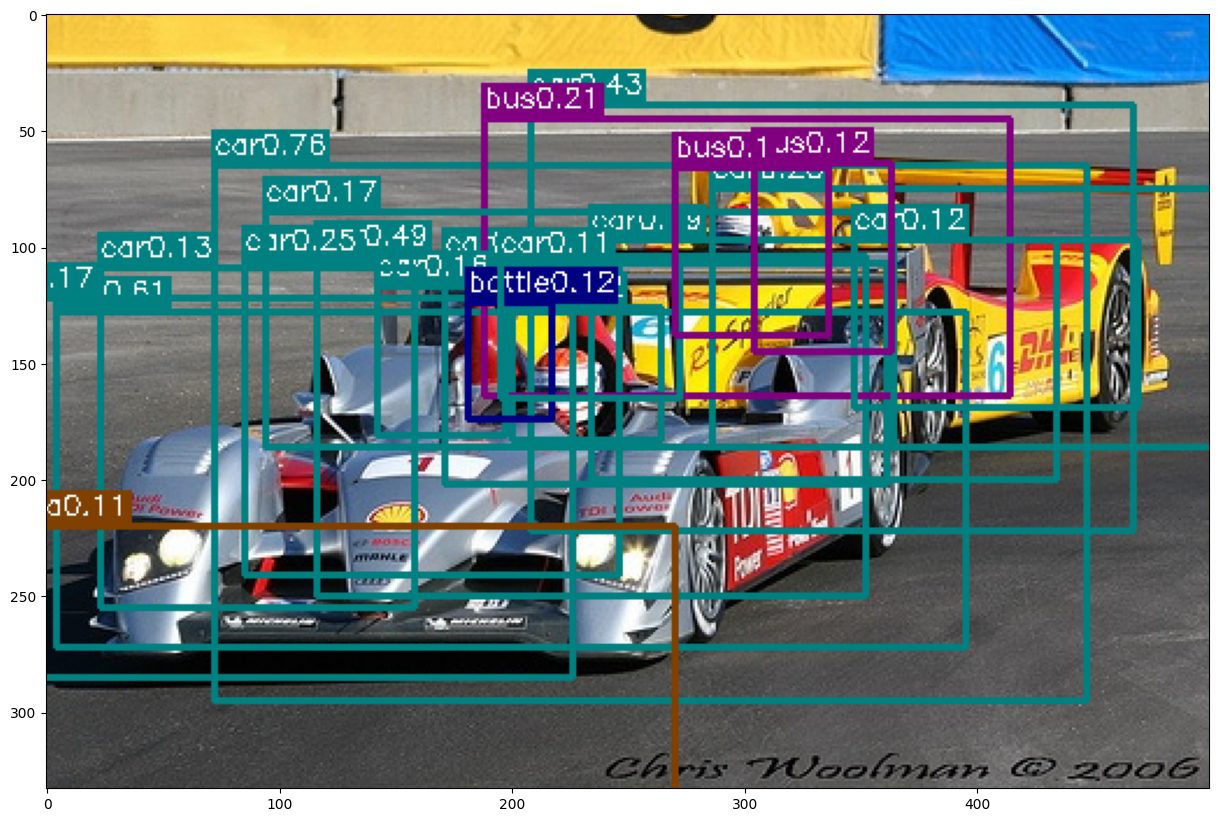

In [16]:
net.eval()

# select random image from test set
image_name = random.choice(test_dataset.fnames)
image = cv2.imread(os.path.join(file_root_test, image_name))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print('predicting...')
result = predict_image(net, image_name, root_img_directory=file_root_test)
for left_up, right_bottom, class_name, _, prob in result:
    color = COLORS[VOC_CLASSES.index(class_name)]
    cv2.rectangle(image, left_up, right_bottom, color, 2)
    label = class_name + str(round(prob, 2))
    text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
    p1 = (left_up[0], left_up[1] - text_size[1])
    cv2.rectangle(image, (p1[0] - 2 // 2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]),
                  color, -1)
    cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1, 8)

plt.figure(figsize = (15,15))
plt.imshow(image)


## Evaluate on Test

To evaluate detection results we use mAP (mean of average precision over each class)

In [17]:
test_aps = evaluate(net, test_dataset_file=annotation_file_test, img_root=file_root_test)

---Evaluate model on test samples---


100%|██████████| 4950/4950 [03:46<00:00, 21.82it/s]


---class aeroplane ap 0.5297665391567923---
---class bicycle ap 0.6168597699804278---
---class bird ap 0.4909534094692494---
---class boat ap 0.2981229495138017---
---class bottle ap 0.13829732506340672---
---class bus ap 0.62832815721498---
---class car ap 0.6368469352906838---
---class cat ap 0.737370396804408---
---class chair ap 0.2728256878044966---
---class cow ap 0.5253658325345902---
---class diningtable ap 0.46703987860838503---
---class dog ap 0.7101942827008727---
---class horse ap 0.7304949419272023---
---class motorbike ap 0.5856523434590042---
---class person ap 0.5326080474437955---
---class pottedplant ap 0.20600715916653914---
---class sheep ap 0.36936096604913515---
---class sofa ap 0.4736465979955407---
---class train ap 0.6432001801836292---
---class tvmonitor ap 0.43226436651164485---
---map 0.5012602883439292---


### Cell added to get intermediate mAP values for students

In [18]:
network_paths = ['./checkpoints/detector_epoch_%d.pth' % epoch for epoch in [5, 10, 20, 30, 40]]+['./checkpoints/detector.pth']
for load_network_path in network_paths:
    print('Loading saved network from {}'.format(load_network_path))
    net_loaded =  resnet50().to(device)
    net_loaded.load_state_dict(torch.load(load_network_path))
    evaluate(net_loaded, test_dataset_file=annotation_file_test, img_root=file_root_test)


Loading saved network from ./checkpoints/detector_epoch_5.pth
---Evaluate model on test samples---


100%|██████████| 4950/4950 [05:59<00:00, 13.77it/s]


---class aeroplane ap 0.35317831841437286---
---class bicycle ap 0.3542688784149932---
---class bird ap 0.22560986711787795---
---class boat ap 0.09340115032484583---
---class bottle ap 0.02503576171931205---
---class bus ap 0.33509348808070993---
---class car ap 0.4218856906860573---
---class cat ap 0.40726399278378667---
---class chair ap 0.056459522429373826---
---class cow ap 0.11623508033886823---
---class diningtable ap 0.14864682894318787---
---class dog ap 0.4424531078579888---
---class horse ap 0.473003188298071---
---class motorbike ap 0.4299885891499586---
---class person ap 0.3839314945017479---
---class pottedplant ap 0.06536569618659183---
---class sheep ap 0.05144035291526439---
---class sofa ap 0.2615283345758528---
---class train ap 0.44151206128398884---
---class tvmonitor ap 0.08995430632754284---
---map 0.25881278551751963---
Loading saved network from ./checkpoints/detector_epoch_10.pth
---Evaluate model on test samples---


100%|██████████| 4950/4950 [05:49<00:00, 14.17it/s]


---class aeroplane ap 0.4348947877104818---
---class bicycle ap 0.5356523812977708---
---class bird ap 0.3336217231810858---
---class boat ap 0.22482381784743427---
---class bottle ap 0.051461919325681164---
---class bus ap 0.5227971637120143---
---class car ap 0.5571132161363597---
---class cat ap 0.599458846686499---
---class chair ap 0.1261030478703383---
---class cow ap 0.30390319634167645---
---class diningtable ap 0.35513381012916---
---class dog ap 0.5182690636252696---
---class horse ap 0.6519325439160626---
---class motorbike ap 0.49101757691338377---
---class person ap 0.4423722255390007---
---class pottedplant ap 0.12426963608775901---
---class sheep ap 0.11951520901396898---
---class sofa ap 0.40553029992345874---
---class train ap 0.5632759662059359---
---class tvmonitor ap 0.26244554345979265---
---map 0.38117959874615664---
Loading saved network from ./checkpoints/detector_epoch_20.pth
---Evaluate model on test samples---


100%|██████████| 4950/4950 [04:20<00:00, 18.97it/s]


---class aeroplane ap 0.44671460214385406---
---class bicycle ap 0.6040776791119746---
---class bird ap 0.42203820341705733---
---class boat ap 0.3187182468080412---
---class bottle ap 0.12241963594395214---
---class bus ap 0.5620370931250562---
---class car ap 0.570719149864484---
---class cat ap 0.689732461778632---
---class chair ap 0.21752300856528003---
---class cow ap 0.4021236243397586---
---class diningtable ap 0.43273246415408184---
---class dog ap 0.5754557183990864---
---class horse ap 0.7083648008233121---
---class motorbike ap 0.5088703423218---
---class person ap 0.4533845072997415---
---class pottedplant ap 0.1717128806797375---
---class sheep ap 0.34857986632738747---
---class sofa ap 0.41657721508876977---
---class train ap 0.5813406477774288---
---class tvmonitor ap 0.30964622452146173---
---map 0.4431384186245449---
Loading saved network from ./checkpoints/detector_epoch_30.pth
---Evaluate model on test samples---


100%|██████████| 4950/4950 [03:50<00:00, 21.45it/s]


---class aeroplane ap 0.5213356726295401---
---class bicycle ap 0.6040414719370081---
---class bird ap 0.4763643044718338---
---class boat ap 0.2815966081081406---
---class bottle ap 0.11530443335391125---
---class bus ap 0.6470968911167286---
---class car ap 0.6254381356141675---
---class cat ap 0.7087136726766725---
---class chair ap 0.2777436206918056---
---class cow ap 0.4764933243470837---
---class diningtable ap 0.4580721385310528---
---class dog ap 0.6757072913466491---
---class horse ap 0.6784703971287741---
---class motorbike ap 0.5883215546451699---
---class person ap 0.514558360383385---
---class pottedplant ap 0.18458964570907804---
---class sheep ap 0.3688043390193937---
---class sofa ap 0.457714837543552---
---class train ap 0.6284072798967226---
---class tvmonitor ap 0.43987317681217186---
---map 0.4864323577981421---
Loading saved network from ./checkpoints/detector_epoch_40.pth
---Evaluate model on test samples---


100%|██████████| 4950/4950 [03:45<00:00, 21.99it/s]


---class aeroplane ap 0.5040103571886079---
---class bicycle ap 0.6080776442011548---
---class bird ap 0.48259666527146705---
---class boat ap 0.3037247254263329---
---class bottle ap 0.13760684633851022---
---class bus ap 0.6269403760005603---
---class car ap 0.649449942831545---
---class cat ap 0.742623783791309---
---class chair ap 0.28905085388437585---
---class cow ap 0.5232839833570377---
---class diningtable ap 0.46385887113705276---
---class dog ap 0.7166063110033207---
---class horse ap 0.7281713509671377---
---class motorbike ap 0.589183383144764---
---class person ap 0.53749963605774---
---class pottedplant ap 0.20532739068382955---
---class sheep ap 0.3678168309770663---
---class sofa ap 0.4613615335843101---
---class train ap 0.6351705220275717---
---class tvmonitor ap 0.44872680933852543---
---map 0.5010543908606109---
Loading saved network from ./checkpoints/detector.pth
---Evaluate model on test samples---


100%|██████████| 4950/4950 [03:52<00:00, 21.31it/s]


---class aeroplane ap 0.5297665391567923---
---class bicycle ap 0.6168597699804278---
---class bird ap 0.4909534094692494---
---class boat ap 0.2981229495138017---
---class bottle ap 0.13829732506340672---
---class bus ap 0.62832815721498---
---class car ap 0.6368469352906838---
---class cat ap 0.737370396804408---
---class chair ap 0.2728256878044966---
---class cow ap 0.5253658325345902---
---class diningtable ap 0.46703987860838503---
---class dog ap 0.7101942827008727---
---class horse ap 0.7304949419272023---
---class motorbike ap 0.5856523434590042---
---class person ap 0.5326080474437955---
---class pottedplant ap 0.20600715916653914---
---class sheep ap 0.36936096604913515---
---class sofa ap 0.4736465979955407---
---class train ap 0.6432001801836292---
---class tvmonitor ap 0.43226436651164485---
---map 0.5012602883439292---


In [19]:
output_submission_csv('my_new_solution.csv', test_aps)